In [1]:
###################################################################################################
# Project: 
#          
# Lenguaje: Python / jupyter
# Description:
#
# References: 
# Git Control:
# Author : Camilo Blanco Vargas - Year: 2020 
# Mail - Web:mail@camiloblanco.com - www.camiloblanco.com
###################################################################################################

In [2]:
# Import the necesary libraries
import pandas as pd
import requests
import numpy as np
import matplotlib.pyplot as plt
import Oanda_Manager as om

In [3]:
# Create an Oanda_Manager object to connect to Oanda API
account = pd.read_csv('Account_details.csv')
API_KEY=account.iloc[0, 0]
Account_ID=account.iloc[0, 1]
Oanda_URL=account.iloc[0, 2]
oandaAcc =  om.Oanda_Manager(API_KEY,Account_ID, Oanda_URL,{'Authorization': f'Bearer {API_KEY}'})
print(oandaAcc.account_list())

(200, {'accounts': [{'id': '101-004-19105515-001', 'tags': []}]})


In [5]:
# Retrieve the index data as a time-series dataframe usign a date range
asset_name="SPX500_USD"
granularity="M"
from_date = pd.to_datetime('1/1/2003')
to_date  = pd.to_datetime('4/30/2021')
candle_data = oandaAcc.get_candles_dates(asset_name, granularity,from_date,to_date)
candle_data.head()

,volume,mid_o,mid_h,mid_l,mid_c,bid_o,bid_h,bid_l,bid_c,ask_o,ask_h,ask_l,ask_c
time,,,,,,,,,,,,,
2003-03-31 22:00:00,16324.0,847.5,924.6,846.8,916.9,847.5,924.6,846.8,916.9,847.5,924.6,846.8,916.9
2003-04-30 21:00:00,15148.0,915.6,965.9,902.6,965.4,915.6,965.9,902.6,965.4,915.6,965.9,902.6,965.4
2003-05-31 21:00:00,175511.0,968.6,1016.8,963.8,974.8,968.6,1016.8,963.8,974.8,968.6,1016.8,963.8,974.8
2003-06-30 21:00:00,244059.0,973.3,1016.1,961.7,989.7,973.3,1016.1,961.7,989.7,973.3,1016.1,961.7,989.7
2003-07-31 21:00:00,197146.0,989.9,1012.8,959.1,1008.4,989.9,1012.8,959.1,1008.4,989.9,1012.8,959.1,1008.4


In [6]:
# Print the info of the resulting timeIndex dataframe
candle_data.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 217 entries, 2003-03-31 22:00:00 to 2021-03-31 21:00:00
Data columns (total 13 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   volume  217 non-null    float64
 1   mid_o   217 non-null    float64
 2   mid_h   217 non-null    float64
 3   mid_l   217 non-null    float64
 4   mid_c   217 non-null    float64
 5   bid_o   217 non-null    float64
 6   bid_h   217 non-null    float64
 7   bid_l   217 non-null    float64
 8   bid_c   217 non-null    float64
 9   ask_o   217 non-null    float64
 10  ask_h   217 non-null    float64
 11  ask_l   217 non-null    float64
 12  ask_c   217 non-null    float64
dtypes: float64(13)
memory usage: 23.7 KB


In [7]:
# Describe the date
index_stats = candle_data.describe()
index_stats = index_stats.transpose()
index_stats

,count,mean,std,min,25%,50%,75%,max
volume,217.0,450490.668203,617361.420834,15148.0,175637.0,257302.0,425373.0,4045294.0
mid_o,217.0,1769.101843,734.341039,732.1,1203.2,1440.8,2170.4,3979.4
mid_h,217.0,1830.582028,768.803011,834.2,1234.7,1499.6,2193.8,4220.0
mid_l,217.0,1710.694931,715.783879,666.3,1168.3,1403.6,2112.4,3976.3
mid_c,217.0,1784.902304,750.723770,733.9,1204.3,1454.8,2177.0,4189.0
bid_o,217.0,1768.924747,734.233811,732.1,1203.2,1440.0,2170.2,3979.1
bid_h,217.0,1830.449355,768.718684,834.2,1234.7,1499.6,2193.6,4219.9
bid_l,217.0,1710.526728,715.667688,666.3,1168.3,1403.6,2112.0,3976.0
bid_c,217.0,1784.754470,750.638480,733.9,1204.3,1454.8,2176.7,4188.8
ask_o,217.0,1769.275438,734.445327,732.1,1203.2,1441.5,2170.7,3979.7


<AxesSubplot:xlabel='time'>

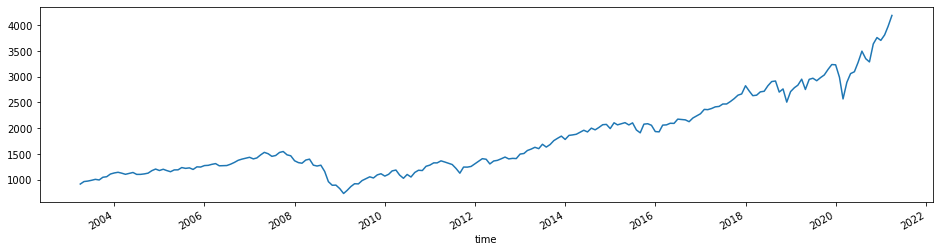

In [8]:
# Plot the medium closing price
plt.figure(figsize=(16,4))
candle_data['mid_c'].plot()